In [1]:
import gymnasium as gym
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

Example from docs, just to make sure we can access the environment

In [2]:

env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

Simple model first. The inputs are an 8 dimensional vector, and the outputs are 4 dimensional vector. The model is a simple 2 layer MLP with 32 hidden units.

In [99]:
hidden_size = 32
class SimplePilot(nn.Module):
    def __init__(self, max_coords):
        super().__init__()
        self.max_coords= torch.tensor(max_coords, dtype=torch.float32)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 4),
        )

    def forward(self, x):
        # normalize the input (disabled at the moment)
        # x = x / self.max_coords
        logits = self.linear_relu_stack(x)
        return logits

Quick test

In [100]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
max_coords = env.observation_space.high
pilot = SimplePilot(max_coords)
observation, info = env.reset()
observation = torch.tensor(observation, dtype=torch.float32)
probs = nn.functional.softmax(pilot(observation),dim=0)
# sample from the distribution
action = torch.multinomial(probs, 1).item()
observation, reward, terminated, truncated, info = env.step(action)
print(f"Action: {action}, Reward: {reward}")
env.close()

Action: 2, Reward: 1.0748424348353012


In [ ]:
max_coords

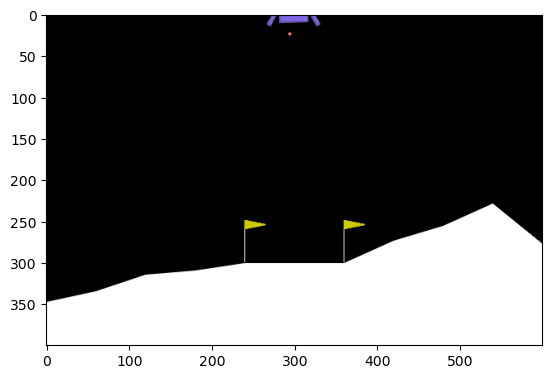

In [101]:
plt.imshow(env.render())

Now we are ready to start building the policy gradient training. I used "Hands on Machine Learning ..." by Geron as a rough guide (the code in the book uses tensorflow and is for the cart pole problem.) I will refer to this as HOML.

In [102]:
# Older version, i think equivalent but not sure
# def play_one_step(env, obs, model, loss_fn):
#     model.zero_grad()
#     obs = torch.tensor(obs, dtype=torch.float32)
#     logits = model(obs)
#     with torch.no_grad():
#        probs = nn.functional.softmax(logits, dim=0)
#        action = torch.multinomial(probs, 1).item()
#     #Compute gradient assuming chosen action was correct
#     loss = loss_fn(logits, torch.tensor(action))
#     loss.backward()
#     grads = [param.grad for param in model.parameters()]
#     next_obs, reward, terminated, truncated, info = env.step(action)
#     return next_obs, reward, terminated, truncated, grads

In [125]:
def play_one_step(env, obs, model, loss_fn):
    model.zero_grad()
    obs = torch.tensor(obs, dtype=torch.float32)
    logits = model(obs)
    probs = nn.functional.softmax(logits, dim=0)
    action = torch.multinomial(probs, 1).item()
    #Compute gradient assuming chosen action was correct
    loss = loss_fn(logits, torch.tensor(action))
    grads = torch.autograd.grad(loss, model.parameters())

    next_obs, reward, terminated, truncated, info = env.step(action)
    return next_obs, reward, terminated, truncated, grads

In [126]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
max_coords = env.observation_space.high
pilot = SimplePilot(max_coords)
observation, info = env.reset()
next_obs, reward, terminated, truncated, grads = play_one_step(env,
                                     observation, pilot, nn.CrossEntropyLoss())
print(len(grads))
env.close()

6


Code copied directly from HOML

In [127]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

Test

In [128]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
max_coords = env.observation_space.high
pilot = SimplePilot(max_coords)
observation, info = env.reset()
all_rewards, all_grads = play_multiple_episodes(env, 3, 1000, pilot, nn.CrossEntropyLoss())
env.close()

Ok so this returns two lists with the rewards and gradients for each episode. Now we need discount the rewards, and normalize them so that they have mean 0 and std 1. This is a standard trick to make the training more stable.  This code is copied from HOML

In [129]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Ok lets try training this

In [141]:
n_iterations = 500
n_episodes_per_update = 20
n_max_steps = 1000
discount_factor = 0.99
loss_fn = nn.CrossEntropyLoss()


Initialize the pilot and environment

In [142]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
max_coords = env.observation_space.high
pilot = SimplePilot(max_coords)
optimizer = torch.optim.Adam(pilot.parameters(), lr=0.005)

Compute mean total rewards for the multiple episodes

In [143]:
def net_rewards(all_rewards):
    return np.mean([sum(rewards) for rewards in all_rewards])

In [144]:
# Training loop
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, pilot, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    for var_index, param in enumerate(pilot.parameters()):
        mean_grads = torch.mean(
            torch.stack([final_reward * all_grads[episode_index][step][var_index]
                         for episode_index, final_rewards in enumerate(all_final_rewards)
                             for step, final_reward in enumerate(final_rewards)]), dim=0)
        all_mean_grads.append(mean_grads)
    #optimizer.zero_grad()
    for grad, param in zip(all_mean_grads, pilot.parameters()):
        param.grad = grad
    optimizer.step()
    if iteration % 10 == 0:
        print(f"Iteration: {iteration}, Mean Reward: {net_rewards(all_rewards)}")


Iteration: 0, Mean Reward: -176.51186634700335
Iteration: 10, Mean Reward: -141.26183329762085
Iteration: 20, Mean Reward: -110.26545440276519
Iteration: 30, Mean Reward: -113.3561256479032
Iteration: 40, Mean Reward: -99.13644443452985
Iteration: 50, Mean Reward: -90.84621547401215
Iteration: 60, Mean Reward: -95.42182329076223
Iteration: 70, Mean Reward: -34.32345902297346
Iteration: 80, Mean Reward: -44.61377877719811


In [ ]:
#from HOML notebook
def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [39]:
env.close()
frames = []
env = gym.make("LunarLander-v2", render_mode="rgb_array")
observation, info = env.reset()
with torch.no_grad():
    for _ in range(1000):
        frames.append(env.render())
        logits = pilot(torch.tensor(observation, dtype=torch.float32))
        probs = nn.functional.softmax(logits, dim=0)
        action = torch.multinomial(probs, 1).item()
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            break

env.close()
plot_animation(frames)

In [94]:
nn.functional.softmax(pilot(torch.tensor(observation, dtype=torch.float32)),dim=0)

tensor([0.2746, 0.2482, 0.2018, 0.2755], grad_fn=<SoftmaxBackward0>)

In [30]:
env.close()

In [32]:
first_paramter = pilot.parameters().__next__()